## Kyle Calabro
## Dr. Tweneboah
## CMPS 620 - Homework Six
## 4 May 2021
---

In [1]:
import os
import random
import sys

import time

import tensorflow as tf
from tensorflow import keras

import graphviz
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
tf.random.set_random_seed(42)

## Data Preparation
---

In [14]:
hr = pd.read_csv("./HR_comma_sep.csv")
hr.rename(columns = {"sales" : "department"}, inplace = True)
hr.shape

(14999, 10)

In [8]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
hr.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

### The data set contains no missing values.

## Exploratory Data Analysis
---

In [11]:
print(hr.department.value_counts())

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64


In [12]:
print(hr.salary.value_counts())

low       7316
medium    6446
high      1237
Name: salary, dtype: int64


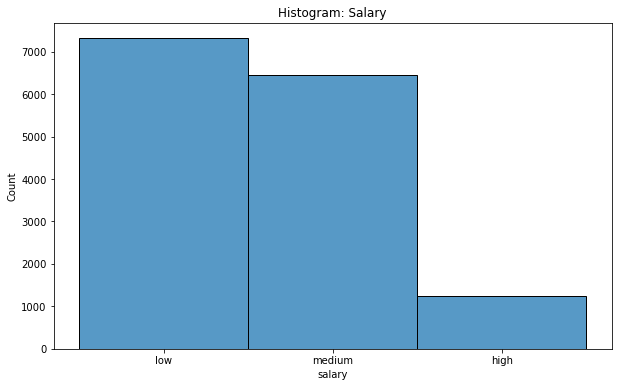

In [13]:
plt.figure(figsize = (10, 6))
sns.histplot(hr.salary).set_title("Histogram: Salary");

In [35]:
pivot_table = hr.pivot_table(values = "satisfaction_level", index = "department", columns = "salary", aggfunc = np.count_nonzero)
pivot_table

salary,high,low,medium
department,,,
IT,83.0,609.0,535.0
RandD,51.0,364.0,372.0
accounting,74.0,358.0,335.0
hr,45.0,335.0,359.0
management,225.0,180.0,225.0
marketing,80.0,402.0,376.0
product_mng,68.0,451.0,383.0
sales,269.0,2099.0,1772.0
support,141.0,1146.0,942.0


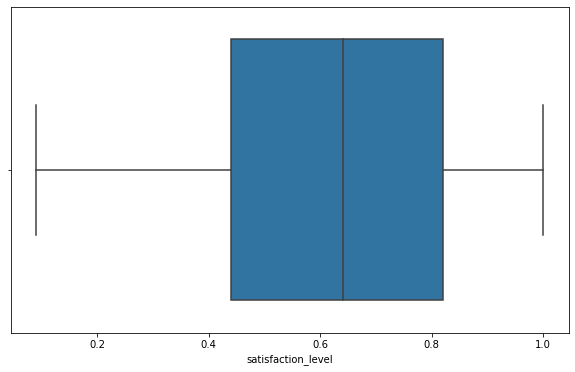

In [16]:
plt.figure(figsize = (10, 6))
sns.boxplot(hr.satisfaction_level);

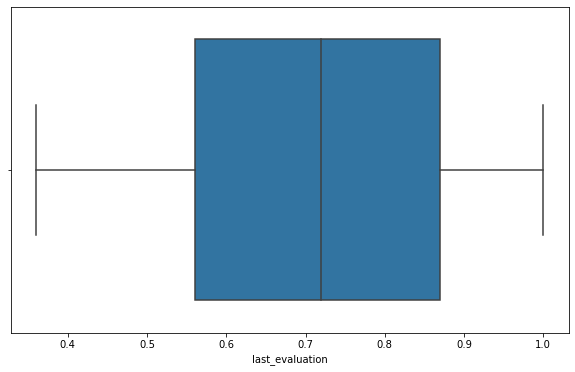

In [17]:
plt.figure(figsize = (10, 6))
sns.boxplot(hr.last_evaluation);

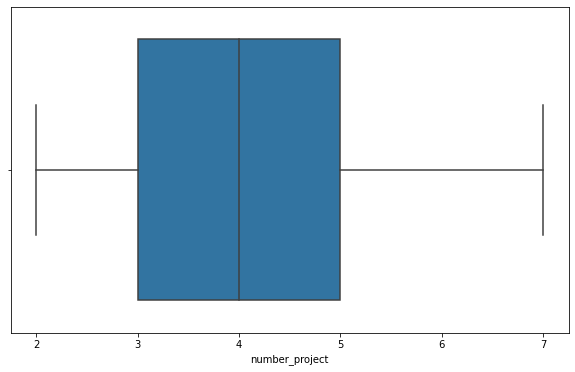

In [18]:
plt.figure(figsize = (10, 6))
sns.boxplot(hr.number_project);

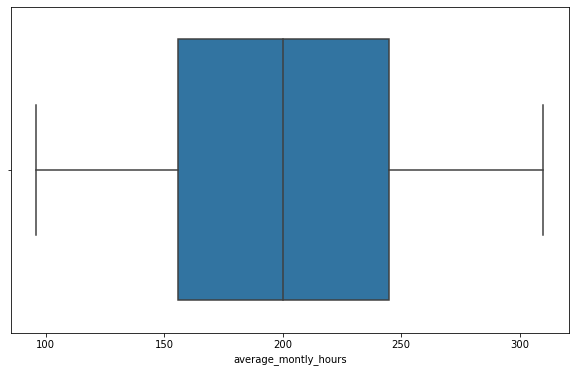

In [19]:
plt.figure(figsize = (10, 6))
sns.boxplot(hr.average_montly_hours);

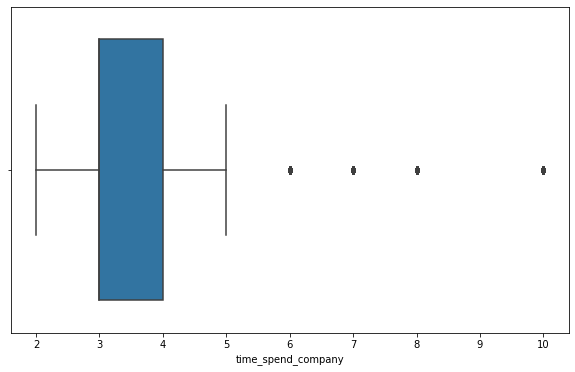

In [20]:
plt.figure(figsize = (10, 6))
sns.boxplot(hr.time_spend_company);

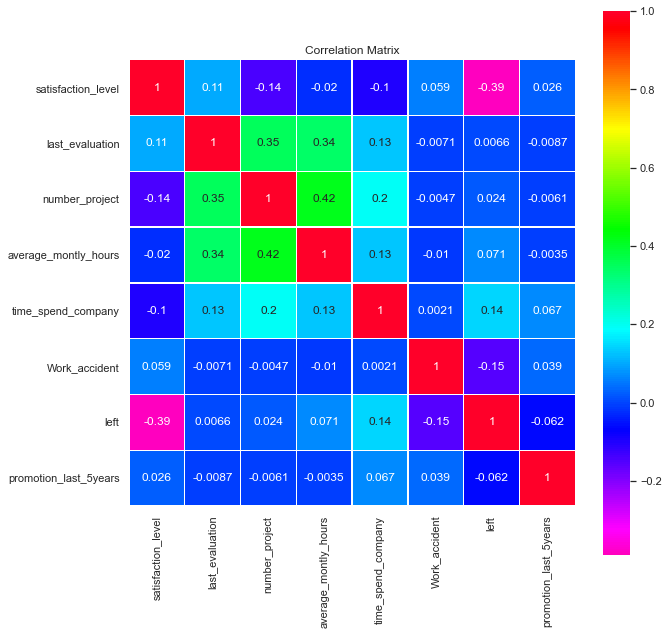

In [42]:
plt.figure(figsize = (10, 10))
sns.set(font_scale = 1)
sns.heatmap(hr.corr(), cmap = "gist_rainbow_r", annot = True, square = True, linewidths = .5)
plt.title("Correlation Matrix");

There exists a negative correlation between the satisfaction level of employees and those who have left the company. The highest positive correlation exists between the number of projects and average monthly hours.

### How many people have left the company?

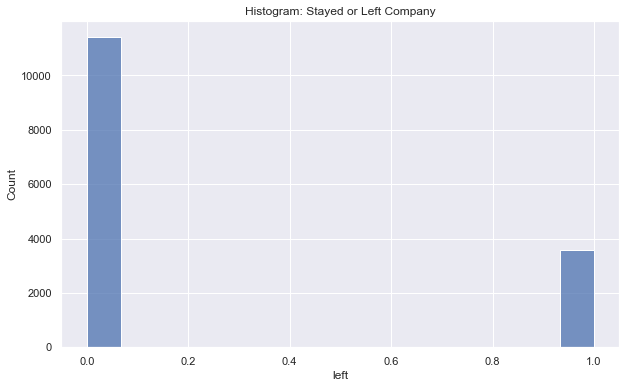

In [24]:
plt.figure(figsize = (10, 6))
sns.histplot(hr.left).set_title("Histogram: Stayed or Left Company");

### How does satisfaction level affect employee retention?

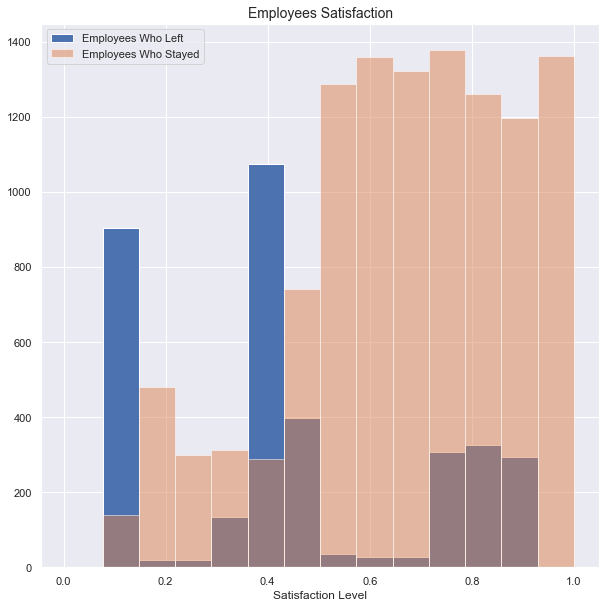

In [41]:
plt.figure(figsize = (10, 10))

bins = np.linspace(0.006,1.000, 15)

plt.hist(hr[hr.left == 1]['satisfaction_level'], bins = bins, alpha = 1, label = 'Employees Who Left')
plt.hist(hr[hr.left == 0]['satisfaction_level'], bins = bins, alpha = 0.5, label = 'Employees Who Stayed')

plt.title('Employees Satisfaction', fontsize = 14)
plt.xlabel('Satisfaction Level')
plt.legend(loc = 'best');

There exists a peak of employees who are incredibly disappointed with the company. There is also another peak at the satisfaction level of .4. There does exist a group within the [.7 : .9] range for satisfaction level that still decided to leave the company.

### How does the number of projects assigned to employees affect their satisfaction level?

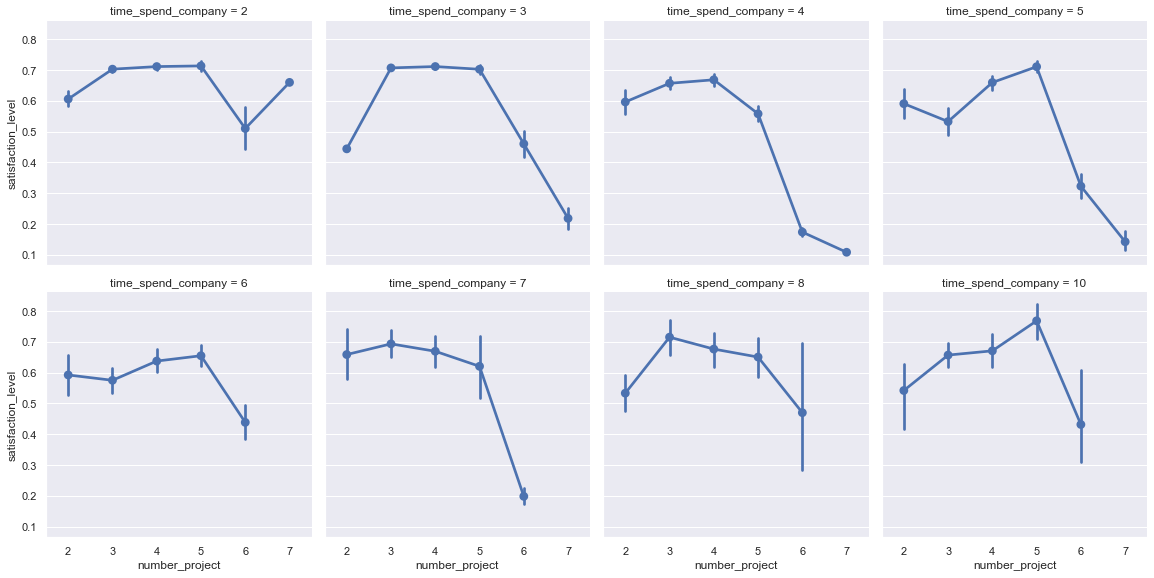

In [40]:
sns.factorplot(data = hr, x = "number_project", y = "satisfaction_level", col = "time_spend_company", col_wrap = 4, size = 4);

From the factor plot we can easily see that there is a considerable drop in satisfaction level when employees are working on six or more projects regardless of how many years the employee has been with the company.

### How does salary affect those leaving the company?

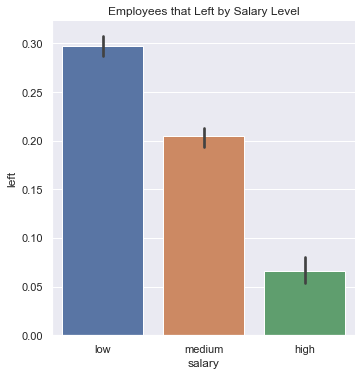

In [61]:
f_plot = sns.factorplot(x = "salary", y = "left", kind = "bar", data = hr)
plt.title("Employees that Left by Salary Level");

Salary does not appear to have a considerable impact on those leaving the company.

### How does time spent with the company impact those leaving?

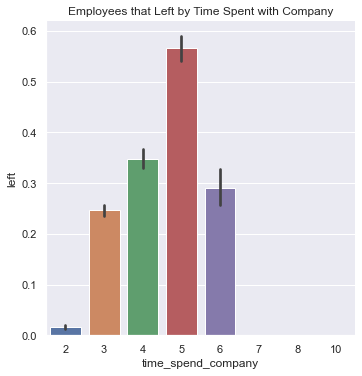

In [54]:
f_plot = sns.factorplot(x = "time_spend_company", y = "left", kind = "bar", data = hr)
plt.title("Employees that Left by Time Spent with Company");

From the plot it is clear that most people leaving the company spent five years there.

## Data Partitioning
---

### Convert Categorical Variables to Ordinal

In [15]:
scale_mapper = {"low" : 1, "medium" : 2, "high" : 3}
hr.salary = hr.salary.replace(scale_mapper)

In [16]:
scale_mapper = {"sales" : 1, "technical" : 2, "support" : 3, "IT" : 4, "product_mng" : 5, 
                "marketing" : 6, "RandD" : 7, "accounting" : 8, "hr" : 9, "management" : 10}
hr.department = hr.department.replace(scale_mapper)

### Split Into Training and Test Sets

In [17]:
X = hr.drop(columns = ["left"], axis = 1).values
y = hr.left.values

In [18]:
sc = StandardScaler()

train_ratio = 0.66

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9899, 9)
X_test: (5100, 9)


In [20]:
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

y_train: (9899,)
y_test: (5100,)


## Deep Neural Networks (DNN)
---

### DNN One:

Utilizes Batch-Normalization

In [46]:
dnn_one = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(600, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(450, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(150, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation = "sigmoid")
])

In [47]:
dnn_one.compile(loss = "binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr = 1e-3),
              metrics = ["accuracy"])

In [48]:
start_time_dnn_one = time.time()

history_one = dnn_one.fit(X_train, y_train, epochs = 150)

end_time_dnn_one = time.time()

Epoch 1/150
9899/9899 [==============================] - 2s 157us/sample - loss: 0.4563 - acc: 0.7972
Epoch 2/150
9899/9899 [==============================] - 1s 124us/sample - loss: 0.3175 - acc: 0.8944
Epoch 3/150
9899/9899 [==============================] - 1s 109us/sample - loss: 0.2692 - acc: 0.9186
Epoch 4/150
9899/9899 [==============================] - 1s 102us/sample - loss: 0.2511 - acc: 0.9262
Epoch 5/150
9899/9899 [==============================] - 1s 115us/sample - loss: 0.2291 - acc: 0.9347
Epoch 6/150
9899/9899 [==============================] - 1s 115us/sample - loss: 0.2067 - acc: 0.9428
Epoch 7/150
9899/9899 [==============================] - 1s 98us/sample - loss: 0.2041 - acc: 0.9420
Epoch 8/150
9899/9899 [==============================] - 1s 108us/sample - loss: 0.1896 - acc: 0.9450
Epoch 9/150
9899/9899 [==============================] - 1s 110us/sample - loss: 0.1841 - acc: 0.9458
Epoch 10/150
9899/9899 [==============================] - 1s 111us/sample - loss: 0

In [49]:
dnn_one.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch multiple                  36        
_________________________________________________________________
dense_12 (Dense)             multiple                  6000      
_________________________________________________________________
batch_normalization_6 (Batch multiple                  2400      
_________________________________________________________________
dense_13 (Dense)             multiple                  270450    
_________________________________________________________________
batch_normalization_7 (Batch multiple                  1800      
_________________________________________________________________
dense_14 (Dense)             multiple                  135300    
_________________________________________________________________
batch_normalization_8 (Batch multiple                 

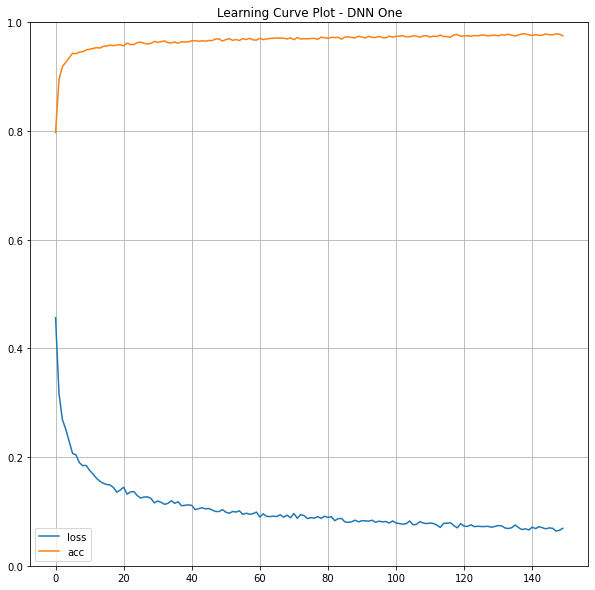

In [50]:
pd.DataFrame(history_one.history).plot(figsize = (10, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Learning Curve Plot - DNN One")
plt.show()

In [51]:
print("DNN One Performance Metrics:", "\n")
print("Elapsed Training Time: {} seconds".format(end_time_dnn_one - start_time_dnn_one), "\n")
dnn_one.evaluate(X_test, y_test)

DNN One Performance Metrics: 

Elapsed Training Time: 168.24746108055115 seconds 

5100/5100 [==============================] - 0s 52us/sample - loss: 0.0994 - acc: 0.9727


[0.09935453007326407, 0.9727451]

### DNN Two:

Utilizes Dropout

In [52]:
dnn_two = keras.models.Sequential([
    keras.layers.Dense(600, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(450, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(300, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(150, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(50, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(1, activation = "sigmoid")
])

In [53]:
dnn_two.compile(loss = "binary_crossentropy",
              optimizer = "nadam",
              metrics = ["accuracy"])

In [54]:
start_time_dnn_two = time.time()

history_two = dnn_two.fit(X_train, y_train, epochs = 150)

end_time_dnn_two = time.time()

Epoch 1/150
9899/9899 [==============================] - 3s 269us/sample - loss: 0.2971 - acc: 0.8999
Epoch 2/150
9899/9899 [==============================] - 2s 226us/sample - loss: 0.1891 - acc: 0.9408
Epoch 3/150
9899/9899 [==============================] - 2s 227us/sample - loss: 0.1683 - acc: 0.9485
Epoch 4/150
9899/9899 [==============================] - 2s 231us/sample - loss: 0.1464 - acc: 0.9599
Epoch 5/150
9899/9899 [==============================] - 2s 220us/sample - loss: 0.1469 - acc: 0.9586
Epoch 6/150
9899/9899 [==============================] - 2s 235us/sample - loss: 0.1396 - acc: 0.9605
Epoch 7/150
9899/9899 [==============================] - 2s 227us/sample - loss: 0.1278 - acc: 0.9644
Epoch 8/150
9899/9899 [==============================] - 2s 233us/sample - loss: 0.1276 - acc: 0.9641
Epoch 9/150
9899/9899 [==============================] - 2s 229us/sample - loss: 0.1285 - acc: 0.9644
Epoch 10/150
9899/9899 [==============================] - 2s 231us/sample - loss: 

In [55]:
dnn_two.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             multiple                  6000      
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_18 (Dense)             multiple                  270450    
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  135300    
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                 

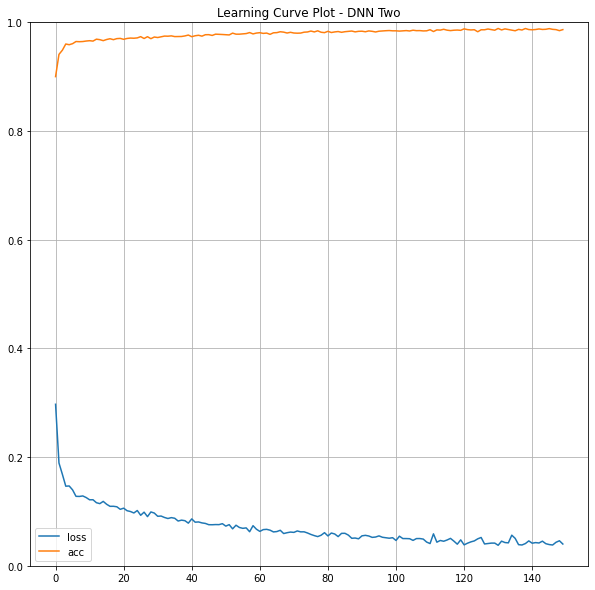

In [56]:
pd.DataFrame(history_two.history).plot(figsize = (10, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Learning Curve Plot - DNN Two")
plt.show()

In [57]:
print("DNN Two Performance Metrics:", "\n")
print("Elapsed Training Time: {} seconds".format(end_time_dnn_two - start_time_dnn_two), "\n")
dnn_two.evaluate(X_test, y_test)

DNN Two Performance Metrics: 

Elapsed Training Time: 343.7559051513672 seconds 

5100/5100 [==============================] - 0s 60us/sample - loss: 0.1944 - acc: 0.9761


[0.1944141926448427, 0.97607845]

## Random Forest
-----

### RF One:

In [40]:
rf_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, random_state = 42)

start_time_rf_one = time.time()

rf_clf.fit(X_train, y_train)

end_time_rf_one = time.time()

y_pred_rf = rf_clf.predict(X_test)

In [41]:
print("Random Forest One Performance Metrics:", "\n")
print("Elapsed Training Time: {} seconds".format(end_time_rf_one - start_time_rf_one), "\n")
print(sk.confusion_matrix(y_test, y_pred_rf), "\n")
print(sk.classification_report(y_test, y_pred_rf), "\n")
print("Accuracy:", sk.accuracy_score(y_test, y_pred_rf))

Random Forest One Performance Metrics: 

Elapsed Training Time: 2.005603075027466 seconds 

[[3875   13]
 [ 128 1084]] 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3888
           1       0.99      0.89      0.94      1212

    accuracy                           0.97      5100
   macro avg       0.98      0.95      0.96      5100
weighted avg       0.97      0.97      0.97      5100
 

Accuracy: 0.9723529411764706


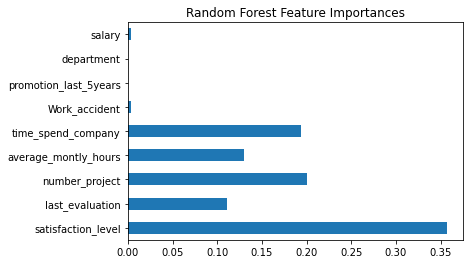

In [42]:
rf_importances = pd.Series(rf_clf.feature_importances_, index = hr.drop(columns = ["left"], axis = 1).columns)
rf_importances.plot(kind = "barh")
plt.title("Random Forest Feature Importances");

### RF Two:

In [43]:
rf_two_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)

start_time_rf_two = time.time()

rf_two_clf.fit(X_train, y_train)

end_time_rf_two = time.time()

y_pred_rf_two = rf_two_clf.predict(X_test)

In [44]:
print("Random Forest Two Performance Metrics:", "\n")
print("Elapsed Training Time: {} seconds".format(end_time_rf_two - start_time_rf_two), "\n")
print(sk.confusion_matrix(y_test, y_pred_rf_two), "\n")
print(sk.classification_report(y_test, y_pred_rf_two), "\n")
print("Accuracy:", sk.accuracy_score(y_test, y_pred_rf_two))

Random Forest Two Performance Metrics: 

Elapsed Training Time: 3.035227060317993 seconds 

[[3880    8]
 [  56 1156]] 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3888
           1       0.99      0.95      0.97      1212

    accuracy                           0.99      5100
   macro avg       0.99      0.98      0.98      5100
weighted avg       0.99      0.99      0.99      5100
 

Accuracy: 0.9874509803921568


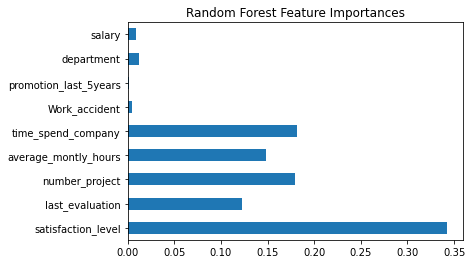

In [45]:
rf_two_importances = pd.Series(rf_two_clf.feature_importances_, index = hr.drop(columns = ["left"], axis = 1).columns)
rf_two_importances.plot(kind = "barh")
plt.title("Random Forest Feature Importances");